In [7]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]

# the output directory to store the data
OUTPUT_DIR = "/data/patrick_res/pseudo"

PRE_INTERVAL = 300   # time in ms before event
POST_INTERVAL = 500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms
NUM_BINS_SMOOTH = 1

Text(0, 0.5, 'Decoder Accuracy')

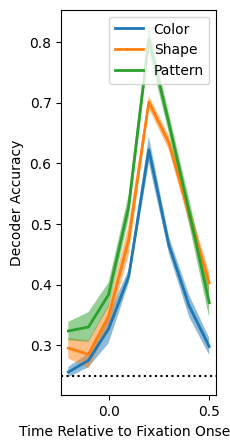

In [9]:
fig, ax = plt.subplots(figsize=(2, 5))

for feature_dim in FEATURE_DIMS:
    accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_fixations_test_accs.npy"))

    visualization_utils.visualize_accuracy_across_time_bins(
        accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{feature_dim}",
        right_align=True, 
    )
ax.legend()
# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
# ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Fixation Onset (s)")
ax.set_ylabel("Decoder Accuracy")

### Visualize Cross Decoding with Fixation and Selection decoders

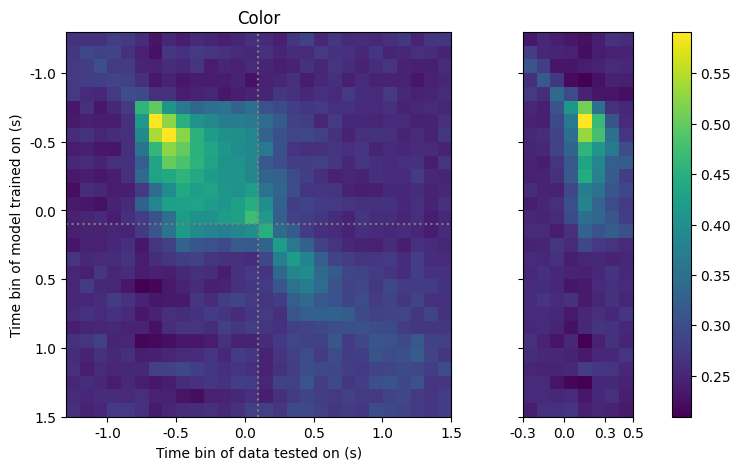

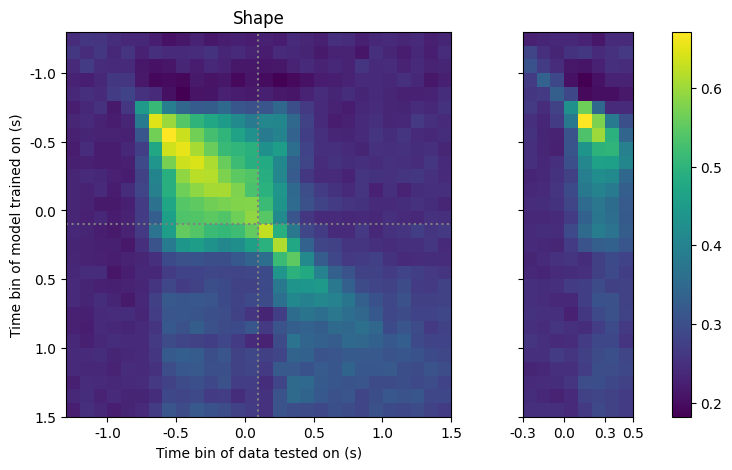

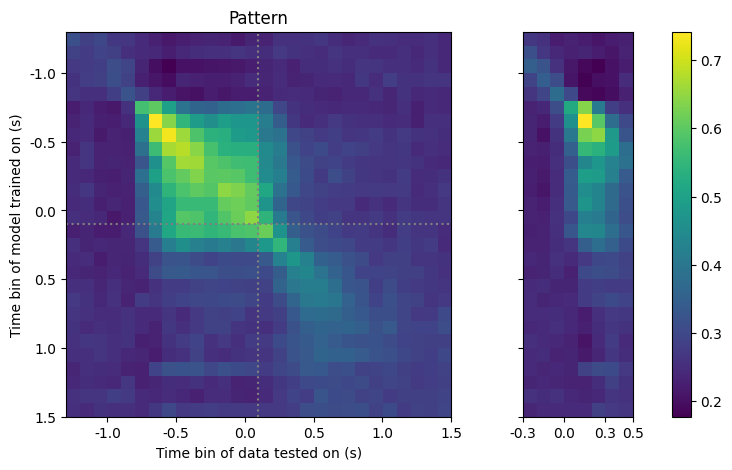

In [10]:
interval_size = 100

for feature_dim in FEATURE_DIMS:
    cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_accs.npy"))
    cross_fix_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_selection_fixations_cross_accs.npy"))
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [7, 2]})
    ax = axs[0]
    colors = ax.matshow(cross_accs)

    ratio = 1000 / interval_size
    tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
    tick_pos = (tick_labels + 1.3) * ratio - 0.5
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)
    ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=1.5)
    ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=1.5)
    ax.set_title(feature_dim)
    ax.set_xlabel("Time bin of data tested on (s)")
    ax.set_ylabel("Time bin of model trained on (s)")

    ax = axs[1]
    colors = ax.matshow(cross_fix_accs)
    ratio = 1000 / interval_size
    x_tick_labels = np.array([-0.3, 0, 0.3, 0.5])
    x_tick_pos = (x_tick_labels + 0.3) * ratio - 0.5
    ax.set_xticks(x_tick_pos)
    ax.set_xticklabels(x_tick_labels)
    ax.xaxis.tick_bottom()
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_labels)

    fig.colorbar(colors, ax=axs)




### Best fixation decoder applied on other timebins of card selection

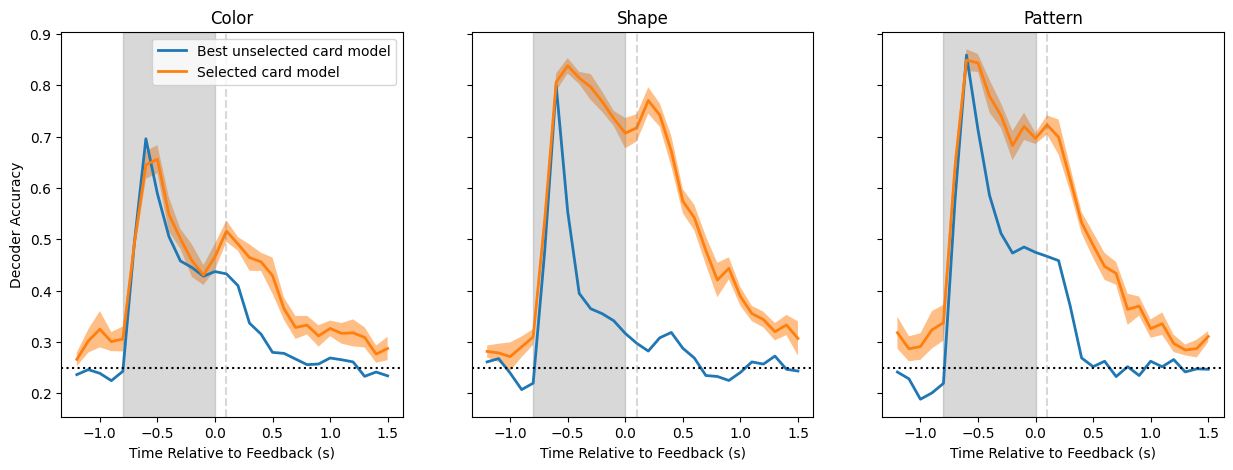

In [19]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, feature_dim in enumerate(FEATURE_DIMS):
    ax = axs[i]
    cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_fixation_on_selections_cross_accs.npy"))
    select_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_rpe_sess_test_accs.npy"))

    visualization_utils.visualize_accuracy_across_time_bins(
        cross_accs.T,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Best unselected card model",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        select_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Selected card model",
        right_align=True, 
    )
    if i == 0: 
        ax.legend()
        ax.set_ylabel("Decoder Accuracy")
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_title(feature_dim)


### Figure out null space of visual fixation

In [7]:
BEST_FIXATION_IDX = 4
models_arrs = []
for feature_dim in FEATURE_DIMS:
    fix_models = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_fixations_models.npy"), allow_pickle=True)
    models_arrs.append(fix_models)
fix_subspace = subspace_utils.get_orth_decoding_axes_for_time_bin(models_arrs, BEST_FIXATION_IDX)

In [15]:
fix_subspace.shape

(756, 12)

In [12]:
fix_null_space = scipy.linalg.null_space(fix_subspace.T)

In [17]:
np.save("/data/patrick_res/fix_null_space.npy", fix_null_space)


In [20]:
fake = np.ones((756, 100))

In [18]:
fix_null_space.shape

(756, 744)

In [21]:
fake @ fix_null_space

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 756 is different from 100)